In [ ]:
# Run this cell to install required libraries
# Note: This may take 2-5 minutes, especially mediapipe which is a large package
# You only need to run this once. If packages are already installed, it will skip them.

# Core ML packages
%pip install torch torchvision torchaudio

# Model and augmentation libraries
%pip install efficientnet_pytorch mediapipe albumentations==1.1.0 timm

# Data science and visualization
%pip install numpy matplotlib pandas seaborn scikit-learn

# Utilities
%pip install opencv-python tqdm ipywidgets


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
     ---------------------------------------- 0.4/51.0 MB 11.6 MB/s eta 0:00:05
      --------------------------------------- 1.2/51.0 MB 15.4 MB/s eta 0:00:04
     - -------------------------------------- 2.5/51.0 MB 22.7 MB/s eta 0:00:03
     -- ------------------------------------- 3.7/51.0 MB 23.6 MB/s eta 0:00:03
     ---- ----------------------------------- 5.6/51.0 MB 25.3 MB/s eta 0:00:02
     ----- ---------------------------------- 6.9/51.0 MB 25.9 MB/s eta 0:00:02
     ------ --------------------------------- 8.7/51.0 MB 27.7 MB/s eta 0:00:02
     ------- ------------------------------- 10.0/51.0 MB 26.6 MB/s eta 0:00:02
     -------- ------------------------------ 11.4/51.0 MB 31.2 MB/s eta 0:00:02
     --------- ----------------------------- 13.0/51.0 MB 32.7 MB/s eta 0:00:02
     ---------- ----------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Shreya Suresh\\projects\\generic\\venv\\Lib\\site-packages\\~umpy.libs\\libscipy_openblas64_-c16e4918366c6bc1f1cd71e28ca36fc0.dll'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Dataset and checkpoint paths (relative to notebook location)
DATA_ROOT = "./dataset"  # folder that contains Cataract/Conjunctivitis/Normal
CHECKPOINT_DIR = "./checkpoints"

# Create checkpoint directory if it doesn't exist
import os
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


In [10]:
import os, random, time, copy
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T




In [ ]:
# This cell is not needed - all packages are installed in Cell 0
# Removed duplicate installation to speed up execution

In [ ]:
# This cell is not needed - all packages are installed in Cell 0
# Removed duplicate installation to speed up execution


In [16]:
from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import mediapipe as mp
import timm  # optional if you want timm-pretrained models


c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [20]:
mp_face_mesh = mp.solutions.face_mesh

def crop_eye_region_bgr(image_bgr):
    """
    Input: BGR numpy image (OpenCV)
    Output: cropped BGR image (fallback to original if no face/eye found)
    """
    h, w = image_bgr.shape[:2]
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as fm:
        res = fm.process(img_rgb)
        if not res.multi_face_landmarks:
            return image_bgr
        lm = res.multi_face_landmarks[0].landmark
        LEFT_EYE_IDX = [33, 133, 159, 145]
        RIGHT_EYE_IDX = [263, 362, 386, 374]
        def get_box(indices):
            xs = [int(lm[i].x * w) for i in indices]
            ys = [int(lm[i].y * h) for i in indices]
            x0, x1 = max(0,min(xs)), min(w, max(xs))
            y0, y1 = max(0,min(ys)), min(h, max(ys))
            pad = int(0.35 * max(y1-y0, x1-x0))  # relative padding
            return max(0,x0-pad), max(0,y0-pad), min(w,x1+pad), min(h,y1+pad)
        lx0, ly0, lx1, ly1 = get_box(LEFT_EYE_IDX)
        rx0, ry0, rx1, ry1 = get_box(RIGHT_EYE_IDX)
        left = image_bgr[ly0:ly1, lx0:lx1]
        right = image_bgr[ry0:ry1, rx0:rx1]
        # choose the larger crop (better detail)
        if left.size==0 and right.size==0:
            return image_bgr
        if left.size >= right.size:
            return left if left.size>0 else right
        else:
            return right

def apply_clahe_rgb(image_bgr):
    """
    Apply CLAHE in LAB space to preserve colors.
    Input/Output: BGR numpy image
    """
    lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final


In [21]:
CLASS_FILTER = ["Cataract", "Conjunctivitis", "Normal"]  # keep only these

# Albumentations transforms
train_aug = A.Compose([
    A.RandomResizedCrop(300,300, scale=(0.8,1.0), ratio=(0.9,1.1)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.4),
    A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(300,300),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class EyeDataset(Dataset):
    def __init__(self, root_dir, split='train', filter_classes=CLASS_FILTER, transform=None):
        self.samples = []
        self.class_to_idx = {}
        classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,d))])
        idx = 0
        for c in classes:
            if c in filter_classes:
                self.class_to_idx[c] = idx
                for f in os.listdir(os.path.join(root_dir,c)):
                    if f.lower().endswith(('.jpg','.jpeg','.png')):
                        self.samples.append((os.path.join(root_dir,c,f), idx))
                idx += 1
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            # fallback blank image
            img_bgr = np.zeros((400,400,3), dtype=np.uint8)
        # Crop eye region
        cropped = crop_eye_region_bgr(img_bgr)
        # Apply CLAHE
        enhanced = apply_clahe_rgb(cropped)
        # Convert BGR->RGB for albumentations
        img_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        if self.transform:
            data = self.transform(image=img_rgb)
            img_tensor = data['image']
        else:
            # basic conversion
            img_tensor = val_aug(image=img_rgb)['image']
        return img_tensor, label

# Create datasets
full_dataset = EyeDataset(DATA_ROOT, split='all', transform=None)
# We'll do an 80-20 split
indices = list(range(len(full_dataset)))
random.seed(42)
random.shuffle(indices)
split = int(0.2 * len(indices))
val_idx = indices[:split]
train_idx = indices[split:]

from torch.utils.data import Subset
# Create train dataset with augmentation
train_dataset_base = Subset(full_dataset, train_idx)
train_dataset = copy.deepcopy(train_dataset_base)
train_dataset.dataset.transform = train_aug

# Create validation dataset with validation transforms
val_dataset_base = Subset(full_dataset, val_idx)
val_dataset = copy.deepcopy(val_dataset_base)
val_dataset.dataset.transform = val_aug

print("Classes mapping:", full_dataset.class_to_idx)
print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))


Classes mapping: {'Cataract': 0, 'Conjunctivitis': 1, 'Normal': 2}
Train samples: 1240 Val samples: 310


In [22]:
# -------------------------
# TRAIN AUGMENTATIONS
# ------------------------
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Extract training labels correctly
train_labels_np = np.array([full_dataset.samples[i][1] for i in train_idx])

# Compute class counts
class_counts = np.bincount(train_labels_np)
class_weights = 1.0 / class_counts

# Assign weight to each sample
weights = class_weights[train_labels_np]

# Create sampler
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

print("Weighted sampler created!")
print("Class counts:", class_counts)
print("Class weights:", class_weights)


Weighted sampler created!
Class counts: [443 283 514]
Class weights: [0.00225734 0.00353357 0.00194553]


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [24]:
num_classes = len(CLASS_FILTER)
model = EfficientNet.from_pretrained('efficientnet-b3')  # loads pretrained
# replace fc
in_f = model._fc.in_features
model._fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_f, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to C:\Users\Shreya Suresh/.cache\torch\hub\checkpoints\efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:03<00:00, 13.2MB/s]


Loaded pretrained weights for efficientnet-b3


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.counter = 0
    def step(self, value):
        if self.best is None or value < self.best - self.min_delta:
            self.best = value
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopper = EarlyStopping(patience=6)


In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import time, os
import copy
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm   # ← added for progress bar

scaler = GradScaler()

# ------------------------------
# TRAIN ONE EPOCH (FAST + PROGRESS BAR)
# ------------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    preds, trues = [], []

    progress = tqdm(loader, desc="Training", leave=False)

    for images, labels in progress:
        images = images.to(device); labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():   # FP16 training
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

        preds.append(torch.argmax(outputs, dim=1).detach().cpu())
        trues.append(labels.detach().cpu())

        progress.set_postfix(loss=loss.item())  # live loss update

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds, average='weighted')

    return running_loss / len(loader.dataset), acc, f1


# ------------------------------
# VALIDATION (PROGRESS BAR)
# ------------------------------
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []

    progress = tqdm(loader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in progress:
            images = images.to(device); labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds.append(torch.argmax(outputs, dim=1).detach().cpu())
            trues.append(labels.detach().cpu())

            progress.set_postfix(loss=loss.item())  # live loss update

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds, average='weighted')

    return running_loss / len(loader.dataset), acc, f1, trues, preds



C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [28]:
# ------------------------------
# TRAINING LOOP
# ------------------------------
best_val_loss = float('inf')
best_state = None
EPOCHS = 25

print("Starting Training...\n")

for epoch in range(1, EPOCHS + 1):

    epoch_percent = (epoch / EPOCHS) * 100
    t0 = time.time()

    print(f"\n===== Epoch {epoch}/{EPOCHS} ({epoch_percent:.1f}%) =====")

    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, optimizer, criterion
    )

    val_loss, val_acc, val_f1, y_true, y_pred = validate(
        model, val_loader, criterion
    )

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f} | "
        f"Time: {time.time()-t0:.1f}s"
    )

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        torch.save(
            {'state_dict': best_state, 'classes': CLASS_FILTER},
            os.path.join(CHECKPOINT_DIR, "best_effnet_b3.pth")
        )
        print("✔ Saved Best Model")

    if early_stopper.step(val_loss):
        print("\n⛔ Early Stopping Triggered — Stopping Training")
        break


print("\nLoading Best Model...")
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, "best_effnet_b3.pth"), map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("✔ Best Model Loaded Successfully")

Starting Training...


===== Epoch 1/25 (4.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/25 | Train Loss: 0.5059, Acc: 0.8056, F1: 0.8040 | Val Loss: 0.2258, Acc: 0.9226, F1: 0.9220 | Time: 616.6s
✔ Saved Best Model

===== Epoch 2/25 (8.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/25 | Train Loss: 0.2011, Acc: 0.9250, F1: 0.9246 | Val Loss: 0.1574, Acc: 0.9548, F1: 0.9542 | Time: 681.5s
✔ Saved Best Model

===== Epoch 3/25 (12.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/25 | Train Loss: 0.1813, Acc: 0.9282, F1: 0.9280 | Val Loss: 0.1140, Acc: 0.9645, F1: 0.9646 | Time: 581.7s
✔ Saved Best Model

===== Epoch 4/25 (16.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/25 | Train Loss: 0.1360, Acc: 0.9508, F1: 0.9507 | Val Loss: 0.1267, Acc: 0.9710, F1: 0.9707 | Time: 575.6s

===== Epoch 5/25 (20.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/25 | Train Loss: 0.1259, Acc: 0.9581, F1: 0.9581 | Val Loss: 0.1912, Acc: 0.9613, F1: 0.9610 | Time: 1489.1s

===== Epoch 6/25 (24.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/25 | Train Loss: 0.0987, Acc: 0.9645, F1: 0.9644 | Val Loss: 0.1318, Acc: 0.9710, F1: 0.9709 | Time: 591.4s

===== Epoch 7/25 (28.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/25 | Train Loss: 0.0891, Acc: 0.9653, F1: 0.9653 | Val Loss: 0.2333, Acc: 0.9323, F1: 0.9325 | Time: 563.8s

===== Epoch 8/25 (32.0%) =====


Training:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\3885266469.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # FP16 training
c:\Users\Shreya Suresh\projects\generic\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

                precision    recall  f1-score   support

      Cataract       0.88      0.96      0.92       101
Conjunctivitis       0.90      0.96      0.93        74
        Normal       0.98      0.88      0.93       135

      accuracy                           0.93       310
     macro avg       0.92      0.93      0.93       310
  weighted avg       0.93      0.93      0.93       310



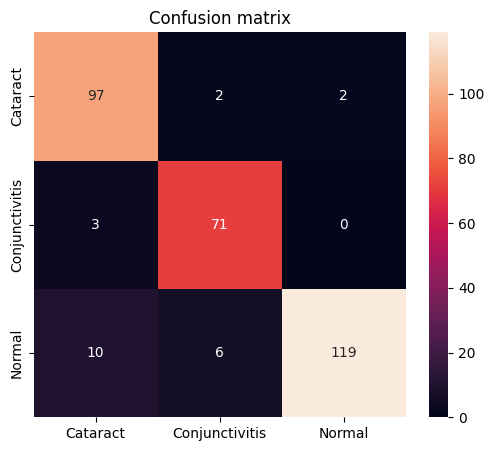

In [30]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(torch.argmax(outputs,1).cpu().numpy())
        all_labels.extend(labels.numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=CLASS_FILTER))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5)); import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_FILTER, yticklabels=CLASS_FILTER); plt.title("Confusion matrix"); plt.show()



In [31]:
SAVE_PATH = "./efficientnet_eye_model.pth"

torch.save({
    "state_dict": model.state_dict(),
    "class_names": CLASS_FILTER
}, SAVE_PATH)

print(f"\n✅ Model saved successfully at: {SAVE_PATH}")



✅ Model saved successfully at: ./efficientnet_eye_model.pth


In [32]:
checkpoint = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint["state_dict"])
CLASS_FILTER = checkpoint["class_names"]
model.eval()

print("🔥 Model loaded successfully and ready for inference!")

🔥 Model loaded successfully and ready for inference!


C:\Users\Shreya Suresh\AppData\Local\Temp\ipykernel_39140\514991573.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_PATH, map_location=devic

In [34]:
import torch.nn.functional as F

# simple TTA transforms: original, hflip, small rotate
tta_transforms = [
    A.Compose([A.Resize(300,300), A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)), ToTensorV2()]),
    A.Compose([A.HorizontalFlip(p=1.0), A.Resize(300,300), A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)), ToTensorV2()]),
    A.Compose([A.Rotate(limit=10, p=1.0), A.Resize(300,300), A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)), ToTensorV2()])
]

def preprocess_for_tta(img_path):
    # read -> crop -> clahe -> rgb
    img_bgr = cv2.imread(img_path)
    cropped = crop_eye_region_bgr(img_bgr)
    enhanced = apply_clahe_rgb(cropped)
    img_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
    return img_rgb

def predict_tta(img_path, model, tta_list=tta_transforms):
    img_rgb = preprocess_for_tta(img_path)
    probs_accum = np.zeros(len(CLASS_FILTER), dtype=np.float32)
    with torch.no_grad():
        for t in tta_list:
            inp = t(image=img_rgb)['image'].unsqueeze(0).to(device)
            out = model(inp)
            probs = F.softmax(out, dim=1).cpu().numpy()[0]
            probs_accum += probs
    probs_accum /= len(tta_list)
    pred_idx = int(np.argmax(probs_accum))
    return CLASS_FILTER[pred_idx], float(probs_accum[pred_idx]), probs_accum


In [35]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Save activation maps during forward pass
        self.forward_hook = target_layer.register_forward_hook(self._save_activations)

        # Save gradients from backward pass
        self.backward_hook = target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output.detach()

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, image_tensor, class_idx=None):
        """
        image_tensor = (1, 3, H, W)
        class_idx = optional target class
        """
        self.model.zero_grad()
        output = self.model(image_tensor)

        # If not specified, take predicted class
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        target_score = output[0, class_idx]
        target_score.backward()

        # 1) grad-CAM weights = mean gradients across spatial dims
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # 2) Weighted sum of activations
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        # 3) ReLU
        cam = F.relu(cam)

        # Normalize to [0,1]
        cam = cam.squeeze().cpu().numpy()
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam


In [ ]:
# Attach Grad-CAM to last conv block of EfficientNet-B3
target_layer = model._blocks[-1]._project_conv
cam = GradCAM(model, target_layer)

print("Grad-CAM ready.")

# Upload images from device
from ipywidgets import FileUpload, Button
from IPython.display import display

upload_dir = "./uploaded_images"
os.makedirs(upload_dir, exist_ok=True)
test_images = []

def process_uploads(b):
    global test_images
    test_images = []
    if upload_widget.value:
        for filename, file_info in upload_widget.value.items():
            file_path = os.path.join(upload_dir, filename)
            with open(file_path, 'wb') as f:
                f.write(file_info['content'])
            test_images.append(file_path)
        print(f"Uploaded {len(test_images)} image(s)")

upload_widget = FileUpload(accept='.jpg,.jpeg,.png', multiple=True)
upload_button = Button(description='Upload', button_style='success')
upload_button.on_click(process_uploads)

display(upload_widget)
display(upload_button)


Grad-CAM ready.


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

results = []

def visualize_prediction_with_cam(img_path, model):

    # ================= 1. PREDICT =================
    pred, conf, probs = predict_tta(img_path, model)
    print(f"\nPrediction → {pred} ({conf*100:.1f}%)\n")

    # ================= 2. PREPROCESS =================
    img_bgr = cv2.imread(img_path)
    cropped = crop_eye_region_bgr(img_bgr)
    enhanced = apply_clahe_rgb(cropped)
    img_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

    # model input
    inp = val_aug(image=img_rgb)['image'].unsqueeze(0).to(device)

    # ================= 3. GRAD-CAM =================
    heat = cam(inp)
    heatmap = cv2.applyColorMap((heat * 255).astype("uint8"), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))

    # overlay
    overlay = (0.55 * img_rgb + 0.45 * heatmap).astype("uint8")

    # ================= 4. SHARP DISPLAY IMAGES =================
    display_img = cv2.resize(img_rgb, (400, 400), interpolation=cv2.INTER_NEAREST)
    display_overlay = cv2.resize(overlay, (400, 400), interpolation=cv2.INTER_NEAREST)

    # ================= 5. PLOT (EYE → OVERLAY → CONFIDENCE) =================
    plt.figure(figsize=(15, 5))

    # 1. Eye Image
    plt.subplot(1, 3, 1)
    plt.imshow(display_img)
    plt.title("Eye (CLAHE)", fontsize=12)
    plt.axis("off")

    # 2. Overlay
    plt.subplot(1, 3, 2)
    plt.imshow(display_overlay)
    plt.title("Grad-CAM Overlay", fontsize=12)
    plt.axis("off")

    # 3. Confidence Plot
    plt.subplot(1, 3, 3)
    bars = plt.bar(CLASS_FILTER, probs * 100)
    plt.ylabel("Confidence (%)", fontsize=12)
    plt.title(f"Prediction: {pred}", fontsize=12)
    plt.ylim(0, 100)

    for bar, p in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width() / 2,
                 p * 100 + 2,
                 f"{p*100:.1f}%",
                 ha='center',
                 fontsize=10)

    plt.tight_layout()
    plt.show()

    # ================ SAVE RESULT =================
    result = {"filename": img_path, "prediction": pred, "confidence": float(conf)}
    for cls, p in zip(CLASS_FILTER, probs):
        result[f"prob_{cls}"] = float(p)
    results.append(result)


In [ ]:
# Process uploaded images
# Equivalent to: for fname in uploaded.keys(): visualize_prediction_with_cam(fname, model)
if test_images:
    for fname in test_images:
        if os.path.exists(fname):
            visualize_prediction_with_cam(fname, model)
        else:
            print(f"⚠️ Warning: File not found: {fname}")
    print("\n✅ Done!")
else:
    print("⚠️ No images uploaded!")
    print("Please upload images using the file upload widget in the previous cell.")


No test images specified. Set 'test_images' list in the previous cell to visualize predictions.
